# Mortalities per Year (1990-2023)

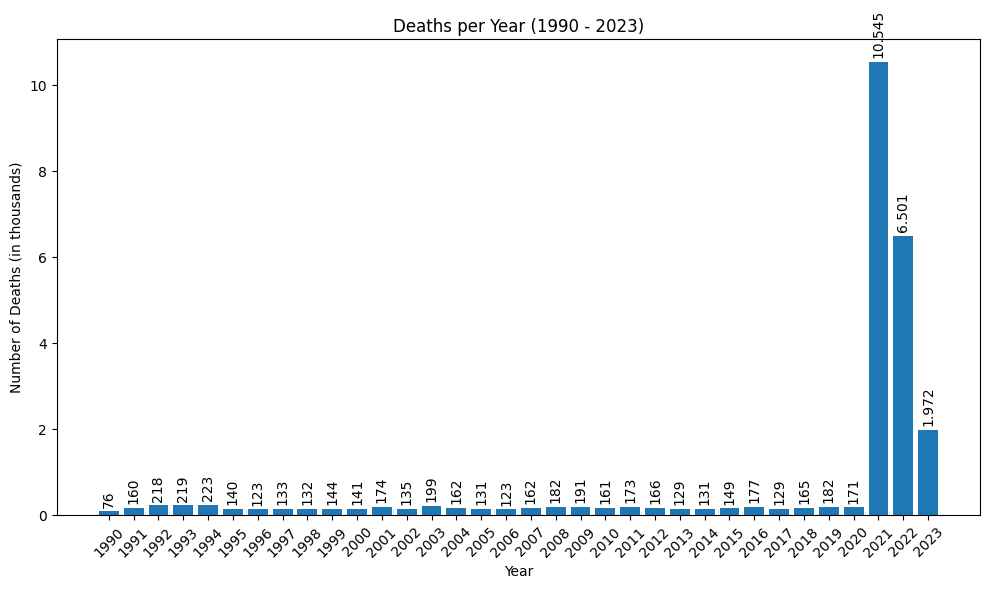

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function for y-axis in thousands
def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

deaths_per_year = {}

for year in range(1990, 2024):
    try:
        filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False)
        deaths = (data['DIED'] == 'Y').sum()
        deaths_per_year[year] = deaths
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(deaths_per_year.keys(), deaths_per_year.values())

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Year')
plt.ylabel('Number of Deaths (in thousands)')
plt.title('Deaths per Year (1990 - 2023)')

# Annotating each bar with its value, formatted with a dot for thousands
for bar in bars:
    height = bar.get_height()
    formatted_height = f'{int(height):,}'.replace(',', '.')  # Format with a dot for thousands
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, formatted_height,
             ha='center', va='bottom', rotation=90)

# Set x-ticks to the years in the dataset
plt.xticks(list(deaths_per_year.keys()), rotation=45)

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Deaths_per_Year.png')
plt.show()

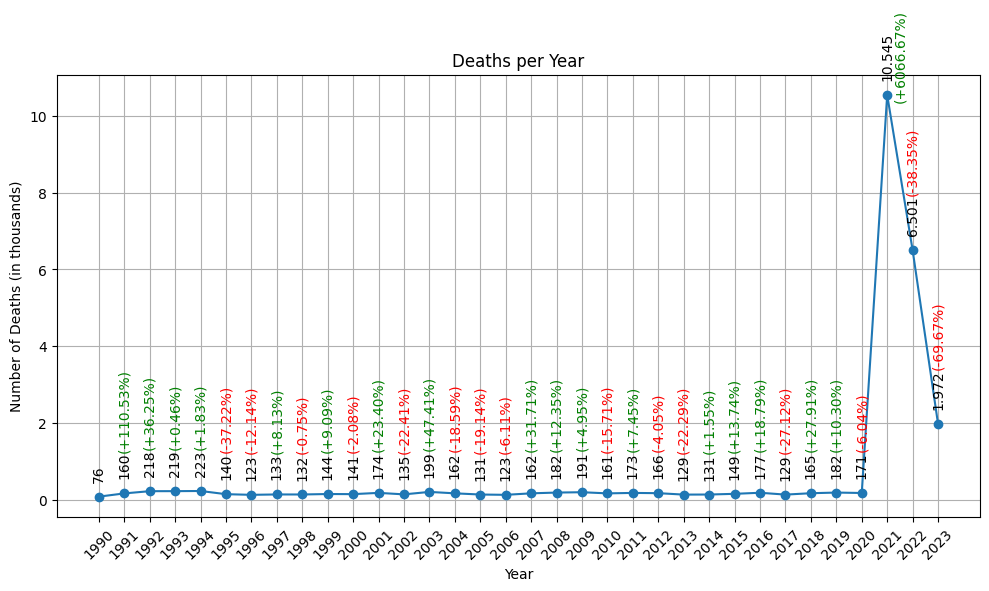

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function for y-axis in thousands
def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

deaths_per_year = {}

for year in range(1990, 2024):
    try:
        filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False)
        deaths = (data['DIED'] == 'Y').sum()
        deaths_per_year[year] = deaths
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert dictionary to a DataFrame
df = pd.DataFrame.from_dict(deaths_per_year, orient='index', columns=['Deaths'])
df.index.name = 'Year'

# Sort the DataFrame by index (year)
df = df.sort_index()

# Calculate percentage change and add it to the DataFrame
df['Percentage Change'] = df['Deaths'].pct_change() * 100
df['Percentage Change'] = df['Percentage Change'].fillna(0)  # Fill NaN (first row) with 0

# Plotting the data as a 2D line graph with original matplotlib blue color
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Deaths'], marker='o', linestyle='-')  # Use 'b' for original blue color
plt.xlabel('Year')
plt.ylabel('Number of Deaths (in thousands)')
plt.title('Deaths per Year')

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value (formatted_deaths) in black
for year, deaths in zip(df.index, df['Deaths']):
    formatted_deaths = f'{int(deaths):,}'.replace(',', '.')  # Format with a dot for thousands
    plt.annotate(formatted_deaths, (year, deaths + 100), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color='black')

# Annotate each point with its percentage change (pct_change) in red or green
for year, pct_change, formatted_deaths in zip(df.index, df['Percentage Change'], df['Deaths']):
    color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
    annotation_text = f'({pct_change:+.2f}%)'
    
        # Skip annotating the percentage value for the first year
    if year == 1990:
        continue
    # Set offset based on formatted_deaths value
    if formatted_deaths < 1000:
        offset = 800
        xoffset = 0
    elif formatted_deaths < 10000:
        offset = 1150
        xoffset = 0
    else:
        offset = -475
        xoffset = 0.5
    plt.annotate(annotation_text, (year + xoffset, formatted_deaths + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color=color)

# Set x-ticks to the years in the dataset
plt.xticks(df.index, rotation=45)

plt.tight_layout()
plt.grid(True)
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Deaths_per_Year_Line.png')
plt.show()

# Mortality Rate per Year (1990-2023)

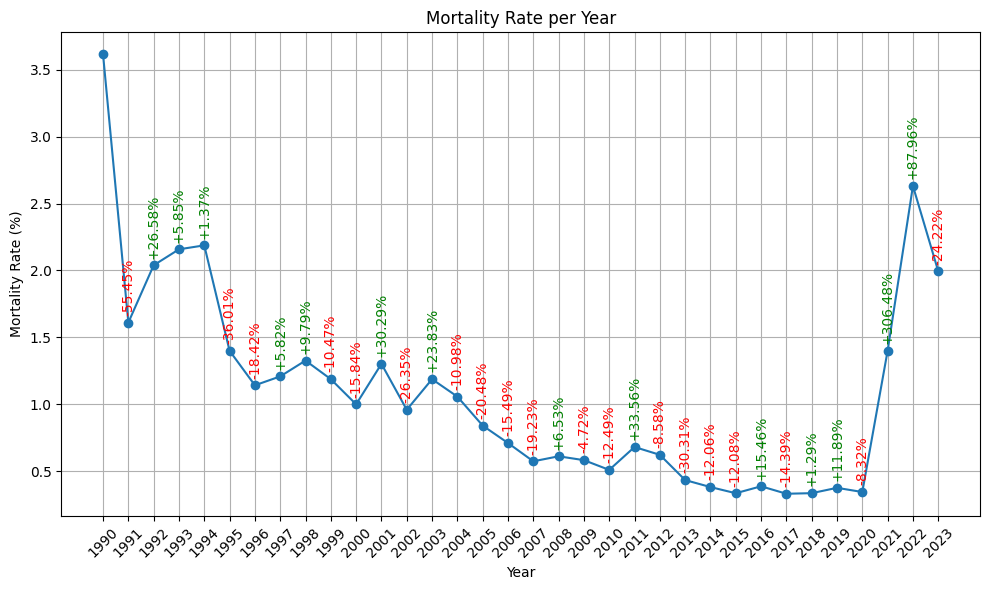

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

mortality_rates_per_year = {}

for year in range(1990, 2024):
    try:
        filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False)
        total_entries = len(data)
        deaths = (data['DIED'] == 'Y').sum()
        mortality_rate = (deaths / total_entries) * 100 if total_entries > 0 else 0
        mortality_rates_per_year[year] = mortality_rate
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Calculate the percentage change compared to the previous year
percent_changes = {}
previous_rate = None
for year, rate in mortality_rates_per_year.items():
    if previous_rate is not None:
        percent_change = ((rate - previous_rate) / previous_rate) * 100 if previous_rate > 0 else 0
        percent_changes[year] = percent_change
    previous_rate = rate

# Plotting the data
plt.figure(figsize=(10, 6))
years = list(mortality_rates_per_year.keys())
rates = list(mortality_rates_per_year.values())
plt.plot(years, rates, marker='o')

plt.xlabel('Year')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate per Year')

# Annotating each point with the percentage change
for year, percent_change in percent_changes.items():
    x_pos = years.index(year)
    y_pos = mortality_rates_per_year[year]
    color = 'green' if percent_change > 0 else 'red'
    sign = '+' if percent_change > 0 else ''
    plt.text(year, y_pos + 0.05, f"{sign}{percent_change:.2f}%", rotation=90, color=color, va='bottom', ha='center')

# Set x-ticks to every year
plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Mortality_Rate_per_Year.png')
plt.show()

# Highest Mortality Rates per Vaccine Type (1990-2023)

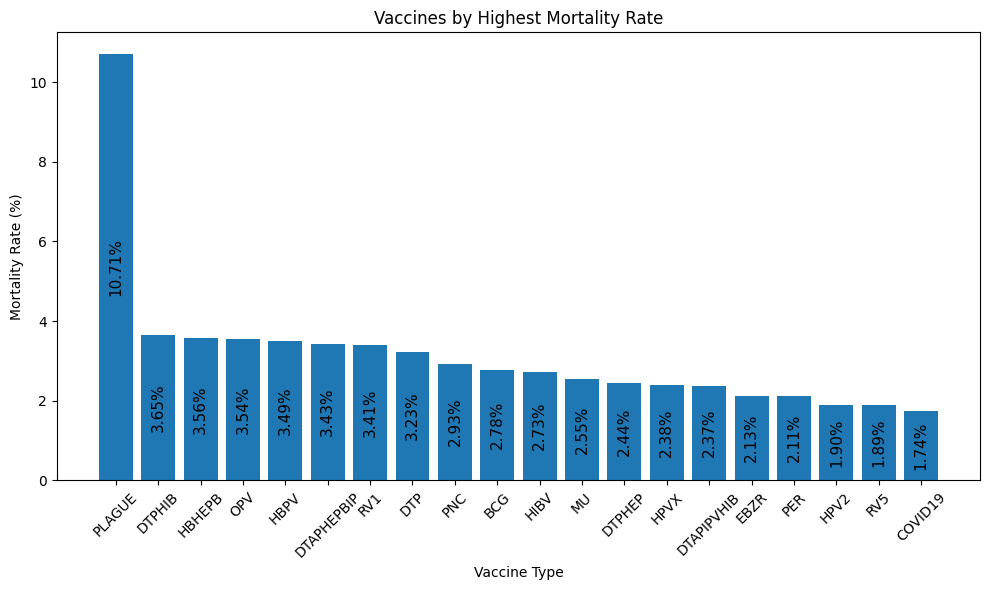

In [1]:
import pandas as pd

vaccine_counts = {}
death_ids = {}

for year in range(1990, 2024):
    try:
        # Load data with only the required columns
        mortality_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        vaccine_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
        mortality_data = pd.read_csv(mortality_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'DIED'])
        vaccine_data = pd.read_csv(vaccine_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])

        # Process vaccine data
        for index, row in vaccine_data.iterrows():
            vax_type = row['VAX_TYPE']
            # Combine "COVID19" and "COVID19-2" into "COVID19"
            if vax_type == "COVID19-2":
                vax_type = "COVID19"
            vaccine_counts[vax_type] = vaccine_counts.get(vax_type, 0) + 1

        # Process mortality data
        deaths_data = mortality_data[mortality_data['DIED'] == 'Y']
        for index, row in deaths_data.iterrows():
            vaers_id = row['VAERS_ID']
            death_vaccine_data = vaccine_data[vaccine_data['VAERS_ID'] == vaers_id]
            for _, vax_row in death_vaccine_data.iterrows():
                vax_type = vax_row['VAX_TYPE']
                # Combine "COVID19" and "COVID19-2" into "COVID19"
                if vax_type == "COVID19-2":
                    vax_type = "COVID19"
                if vax_type in death_ids:
                    if vaers_id not in death_ids[vax_type]:
                        death_ids[vax_type].add(vaers_id)
                else:
                    death_ids[vax_type] = {vaers_id}
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Calculate mortality rates
mortality_rates = {}
for vax_type in vaccine_counts:
    deaths = len(death_ids.get(vax_type, []))
    mortality_rate = (deaths / vaccine_counts[vax_type]) * 100 if vaccine_counts[vax_type] > 0 else 0
    mortality_rates[vax_type] = mortality_rate

# Sort and select top 20 vaccines
top_20_vaccines = sorted(mortality_rates.items(), key=lambda item: item[1], reverse=True)[:20]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bars = plt.bar([item[0] for item in top_20_vaccines], [item[1] for item in top_20_vaccines])
plt.xlabel('Vaccine Type')
plt.ylabel('Mortality Rate (%)')
plt.title('Vaccines by Highest Mortality Rate')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.2f}%', ha='center', va='center', fontsize=11, color='black', rotation=90)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Highest_Mortality_Rate_per_Vaccine_Type.png')
plt.show()


In [59]:
import pandas as pd

plague_vaccine_type = "PLAGUE"
plague_vaccine_count = 0
plague_deaths_count = 0
vaccine_death_counts = {}

for year in range(1990, 2024):
    try:
        # Load data with only the required columns
        vaccine_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
        vaccine_data = pd.read_csv(vaccine_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])

        # Process vaccine data
        for index, row in vaccine_data.iterrows():
            if row['VAX_TYPE'] == plague_vaccine_type:
                plague_vaccine_count += 1

        # Process mortality data
        mortality_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        mortality_data = pd.read_csv(mortality_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'DIED'])
        deaths_data = mortality_data[mortality_data['DIED'] == 'Y']

        for index, row in deaths_data.iterrows():
            vaers_id = row['VAERS_ID']
            if vaers_id in vaccine_data['VAERS_ID'].values:
                vaccine_type = vaccine_data.loc[vaccine_data['VAERS_ID'] == vaers_id, 'VAX_TYPE'].values[0]
                vaccine_death_counts[vaccine_type] = vaccine_death_counts.get(vaccine_type, 0) + 1
                if vaccine_type == plague_vaccine_type:
                    plague_deaths_count += 1

    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Print the number of people who received the "PLAGUE" vaccine and how many of them died
print(f"Number of people who received the '{plague_vaccine_type}' vaccine: {plague_vaccine_count}")
print(f"Number of deaths among people who received the '{plague_vaccine_type}' vaccine: {plague_deaths_count}")

# Plotting and further analysis
import matplotlib.pyplot as plt
# Rest of your plotting code here...


Number of people who received the 'PLAGUE' vaccine: 28
Number of deaths among people who received the 'PLAGUE' vaccine: 3


In [60]:
3/28

0.10714285714285714